# M4 | Research Investigation Notebook

In this notebook, you will do a research investigation of your chosen dataset in teams. You will begin by formally selecting your research question (task 0), then processing your data (task 1), creating a predictive model (task 2), evaluating your model's results (task 3), and describing the contributions of each team member (task 4).

For grading, please make sure your notebook has all cells run and is stored in your team's [Github Classroom repository](https://classroom.github.com/a/CNxME27U). You will also need to write a short, 2 page report about your design decisions as a team, to be stored in your repository. The Milestone 4 submission will be the contents of your repository at the due date (April 28 at 23:59 CET).

## Brief overview of Calcularis
[Calcularis](https://school.alemira.com/de/calcularis/) by Alemira School is a mathematics learning program developed with neuroscientists and computer scientists from ETH Zurich. It promotes the development and interaction of the different areas of the brain that are responsible for processing numbers and quantities and solving mathematical tasks. Calcularis can be used from 1st grade to high school. Children with dyscalculia also benefit in the long term and overcome their arithmetic weakness.

The Calcularis dataset has three main tables:
* ***users***: meta information about users (i.e. total time spent learning with Calcularis, geographic location).
* ***events***: events done by the users in the platform (i.e. playing a game, selecting a new animal in the zoo simulation).
* ***subtasks***: sub-tasks with answer attempts solved by users, primarily in the context of game events.

These tables and useful metadata information are described in detail in the [Milestone 2 data exploration notebook](https://github.com/epfl-ml4ed/mlbd-2023/blob/main/project/milestone-02/m2_calcularis_sciper.ipynb).

We have provided access to the [full dataset](https://moodle.epfl.ch/mod/forum/discuss.php?d=88179) (~65k users) and a randomly selected subset (~1k users from M2). We have also provided access to a [test account to experiment with Calcularis](https://moodle.epfl.ch/mod/forum/discuss.php?d=88094). You should provide arguments and justifications for all of your design decisions throughout this investigation. You can use your M3 responses as the basis for this discussion.

In [1]:
# Import the tables of the data set as dataframes.
import time
start = time.time()
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt

DATA_DIR = './../data' # You may change the directory

# You can use the nrows=X argument in pd.read_csv to truncate your data
users_small = pd.read_csv('{}/calcularis_small_users.csv'.format(DATA_DIR), index_col = 0)
events_small = pd.read_csv('{}/calcularis_small_events.csv'.format(DATA_DIR), index_col = 0)
subtasks_small = pd.read_csv('{}/calcularis_small_subtasks.csv'.format(DATA_DIR), index_col = 0)
users_full = pd.read_csv(f'{DATA_DIR}/full_calcularis_users.csv', index_col = 0)
events_full = pd.read_csv(f'{DATA_DIR}/full_calcularis_events.csv', index_col = 0)
subtasks_full = pd.read_csv(f'{DATA_DIR}/full_calcularis_subtasks.csv', index_col = 0)

## Task 0: Research Question

**Research question:**
For this milestone we focus on detecting wheel-spinning behaviour of Calcularis Users. This is a time series analysis. We rely on features that were proven to be useful in various scientific papers which had to goal of detecting wheel-spinning on different datasets. Our main guide line was the paper [Towards Detecting Wheel-Spinning Future Failure in Mastery Learning](https://www.researchgate.net/publication/281716991_Towards_Detecting_Wheel-Spinning_Future_Failure_in_Mastery_Learning)

## Task 1: Data Preprocessing

In this section, you are asked to preprocess your data in a way that is relevant for the model. Please include 1-2 visualizations of features / data explorations that are related to your downstream prediction task.

In [2]:
#Preprocess given data frames (clean out data)

#remove event entries which have 0 subtasks
events_cleaned = events_full[(events_full.subtasks != "[]") & ~events_full.subtasks.isna()]

#remove event/subtasks entries which have no start value, no skill_id, no correct value
subtasks_cleaned = subtasks_full[~subtasks_full.correct.isna()]
subtasks_small = subtasks_small[~subtasks_small.correct.isna()]
events_cleaned = events_cleaned[~events_cleaned.start.isna() & ~events_cleaned.skill_id.isna()]

subtasks_cleaned.drop_duplicates(inplace = True)
events_cleaned.drop_duplicates(inplace = True)

print(f"Small:: Users: {len(users_small)}, Events: {len(events_small)}, Subtasks: {len(subtasks_small)}")
print(f"Full:: Users: {len(users_full)}, Events: {len(events_full)}, Subtasks: {len(subtasks_full)}")
events_cleaned.head(1)

Small:: Users: 1000, Events: 34094, Subtasks: 55047
Full:: Users: 64932, Events: 2185200, Subtasks: 3502884


,user_id,mode,game_name,learning_time_ms,subtasks,number_range,start,end,skill_id,type
event_id,,,,,,,,,,
1,2,NORMAL,Subitizing,13094.0,"[{'hasProperResult': True, 'range': 'R10', 'co...",R10,2020-08-20T07:13:50.876Z,2020-08-20T07:14:30.108Z,1.0,task


In [3]:
# Your code for data processing goes here
# Select the proper dataframe (small set or full set)
events = events_cleaned
subtasks = subtasks_cleaned
# Select subtasks for which we have events
subtasks = subtasks[subtasks['event_id'].isin(events.index)]
# Create dataframe for developing features
processed_df = events.copy()
processed_df = processed_df[processed_df.type == 'task']
# Filter out irrelvant columns
processed_df = processed_df[['user_id', 'skill_id', 'learning_time_ms', 'start']]
processed_df = processed_df.reset_index()
processed_df

,event_id,user_id,skill_id,learning_time_ms,start
0,1,2,1.0,13094.0,2020-08-20T07:13:50.876Z
1,3,2,3.0,15879.0,2020-08-21T07:02:20.112Z
2,4,2,18.0,6075.0,2020-08-24T07:02:59.855Z
3,5,2,19.0,6910.0,2020-08-26T06:47:21.504Z
4,6,2,54.0,7507.0,2020-08-26T07:20:58.766Z
...,...,...,...,...,...
2152562,2399317,64997,179.0,6075.0,2020-03-24T09:12:33.561Z
2152563,2399318,64997,167.0,2621.0,2020-03-26T07:43:29.873Z
2152564,2399319,64997,178.0,68768.0,2020-03-28T08:33:44.445Z
2152565,2399320,64997,181.0,8130.0,2020-10-28T11:10:16.172Z


**Features to produce:** 
* correct response count
* correct response percentage 
* correct response in a row count
* correct response in a row percentage
* time on current skill
* skill id  

with the exception of skill id, each feature is aggregated on a (user, skill) pair  
  
**Additional/Intermediary features:**
* correct
* pracitce opportunity (po)
* optimistic, pessimistic, and true labels  
  
For further description of the features please see the included report

Feature collection represented the bulk of the work for this milestone. After implementing all features, we went back through the code and improved efficiency for many features, (avoiding costly methods such as .iterrows and .apply). Many cells went from taking 1 minute on the small dataset to near instantaneous. The initial implementations are included below as comments for the sake of completeness.

**Assumptions:** the relation between subtasks and events was not clearly documented, and TA clarification didn't clear things up, so we have operated under the assumption, that each event represents a practice opportunity, with each subtask representing an attempt. We assume that subtasks are in chronological order, which we verified by manually checking timestamps. If subtasks had the same timestamp, we considered the first one.

### Correct feature  
This field is needed to aggregate both the total count and streak counts. It represents whether a user provided a correct response on their first attempt for this practice opportunity.  

In [4]:
'''
print(processed_df2.head(5))
processed_df2['correct'] = processed_df2.apply(
    lambda row: subtasks[subtasks.event_id == row.event_id].iloc[0].correct, axis = 1
)
'''
first_subtask_for_event = pd.DataFrame()
first_subtask_for_event['correct'] = subtasks.groupby(['event_id']).first()['correct']
processed_df = pd.merge(first_subtask_for_event, processed_df, on = 'event_id', how = 'left')
processed_df


,event_id,correct,user_id,skill_id,learning_time_ms,start
0,1,False,2,1.0,13094.0,2020-08-20T07:13:50.876Z
1,3,True,2,3.0,15879.0,2020-08-21T07:02:20.112Z
2,4,True,2,18.0,6075.0,2020-08-24T07:02:59.855Z
3,5,True,2,19.0,6910.0,2020-08-26T06:47:21.504Z
4,6,True,2,54.0,7507.0,2020-08-26T07:20:58.766Z
...,...,...,...,...,...,...
2152562,2399317,True,64997,179.0,6075.0,2020-03-24T09:12:33.561Z
2152563,2399318,True,64997,167.0,2621.0,2020-03-26T07:43:29.873Z
2152564,2399319,True,64997,178.0,68768.0,2020-03-28T08:33:44.445Z
2152565,2399320,False,64997,181.0,8130.0,2020-10-28T11:10:16.172Z


### PO feature
This feature represents the timestep of our time series data.

In [5]:
'''
processed_df['po'] = processed_df.apply(
    lambda row: processed_df[(processed_df.user_id == row.user_id) & (processed_df.skill_id == row.skill_id) & (processed_df.start <= row.start)]['event_id'].count(),
    axis = 1
)
processed_df
'''
processed_df['po'] = processed_df.groupby(['skill_id', 'user_id']).cumcount() + 1
processed_df[(processed_df.user_id == 64997) & (processed_df.skill_id == 179)]
#processed_df


,event_id,correct,user_id,skill_id,learning_time_ms,start,po
2152530,2399282,False,64997,179.0,6720.0,2019-06-21T10:26:20.923Z,1
2152531,2399283,False,64997,179.0,7568.0,2019-07-04T12:44:54.850Z,2
2152532,2399284,False,64997,179.0,7605.0,2019-08-19T12:12:58.289Z,3
2152534,2399286,False,64997,179.0,7651.0,2019-08-27T10:50:33.716Z,4
2152549,2399301,True,64997,179.0,6085.0,2019-12-09T07:27:16.757Z,5
2152550,2399303,True,64997,179.0,6076.0,2019-12-17T14:50:26.030Z,6
2152553,2399306,False,64997,179.0,6076.0,2020-01-13T18:15:04.501Z,7
2152562,2399317,True,64997,179.0,6075.0,2020-03-24T09:12:33.561Z,8


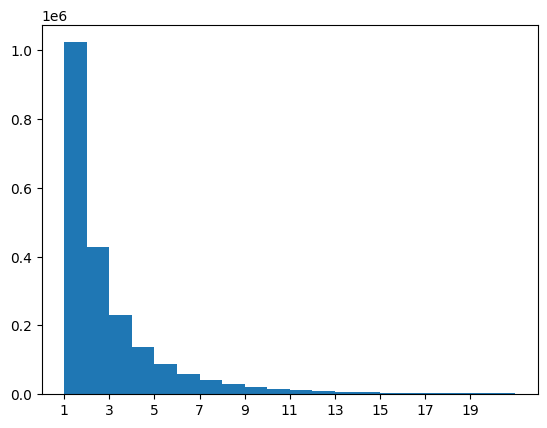

In [6]:
plt.hist(processed_df.po, bins = 20, range = (1,21))
plt.xticks(np.arange(1,20,2))
plt.show()

We observe that PO drops off rapidly (apparently exponentially), this visualization also confirms that the practice opportunity cut off which we use in downstream processing is justified and doesn't remove too many data points

### Correct Response Count Feature  
This feature represents how many answers the user has gotten correct on the first attempt for the associated skill, up to and including this practice opportunity

In [7]:
'''processed_df['correct_response_count'] = processed_df.apply(
    lambda row: processed_df[(processed_df.user_id == row.user_id) & (processed_df.skill_id == row.skill_id) & (processed_df.start < row.start)]['correct'].sum(),
    axis = 1
)'''

processed_df['correct_response_count'] = processed_df.groupby(['user_id', 'skill_id']).correct.cumsum()

processed_df[(processed_df.user_id == 4) & (processed_df.skill_id == 51)]

,event_id,correct,user_id,skill_id,learning_time_ms,start,po,correct_response_count
324,417,True,4,51.0,6684.0,2021-10-25T06:32:20.745Z,1,1
340,434,True,4,51.0,7612.0,2021-12-02T13:06:23.709Z,2,2
343,437,True,4,51.0,7552.0,2021-12-09T13:07:30.688Z,3,3
352,447,False,4,51.0,7622.0,2022-05-20T07:26:43.853Z,4,3
359,455,True,4,51.0,7356.0,2022-06-02T09:37:29.947Z,5,4
365,464,True,4,51.0,7178.0,2022-06-24T09:16:53.320Z,6,5
381,481,True,4,51.0,7388.0,2022-10-07T06:36:00.802Z,7,6


### Correct Response Percentage Feature  
This feature captures what percent of practice opportunities the user has gotten correct on this skill, up to and including the current opportunity

In [8]:
'''
processed_df['correct_response_percentage'] = processed_df.apply(
    lambda row: row.correct_response_count / (row.po - 1) if row.po > 1 else 0,
    axis = 1
)
'''

processed_df['correct_response_percentage'] = processed_df['correct_response_count'] / processed_df['po']
processed_df['correct_response_percentage'].replace(np.NaN, 0, inplace = True)

processed_df[(processed_df.user_id == 64997) & (processed_df.skill_id == 179)]

,event_id,correct,user_id,skill_id,learning_time_ms,start,po,correct_response_count,correct_response_percentage
2152530,2399282,False,64997,179.0,6720.0,2019-06-21T10:26:20.923Z,1,0,0.000000
2152531,2399283,False,64997,179.0,7568.0,2019-07-04T12:44:54.850Z,2,0,0.000000
2152532,2399284,False,64997,179.0,7605.0,2019-08-19T12:12:58.289Z,3,0,0.000000
2152534,2399286,False,64997,179.0,7651.0,2019-08-27T10:50:33.716Z,4,0,0.000000
2152549,2399301,True,64997,179.0,6085.0,2019-12-09T07:27:16.757Z,5,1,0.200000
2152550,2399303,True,64997,179.0,6076.0,2019-12-17T14:50:26.030Z,6,2,0.333333
2152553,2399306,False,64997,179.0,6076.0,2020-01-13T18:15:04.501Z,7,2,0.285714
2152562,2399317,True,64997,179.0,6075.0,2020-03-24T09:12:33.561Z,8,3,0.375000


### Choosing cutoff for practice opportunities
There are three points which influenced how we set the cutoff for practice opportunity, ie. for which po field values and above do we drop the data.
1. Not wanting to eliminate too much data; choosing a cutoff of 10 we only lose 3.6% of our data (see below)  
2. In many papers on this topic, cutoffs are in the range of 10 to 15 so we wanted to choose something similar for the sake of comparison to existing literature.  
3. There is a tradeoff between having too large and too small cutoff values; too small artificially boosts the number of wheelspinning students by not providing enough time to achieve mastery, while too large leads to a larger porportion of indeterminate cases, as wheelspinning users who don't have enough practice opportunities are reclassified as indeterminate. (see report)

In [9]:
PO_CUTOFF = 10
before = processed_df.copy()
processed_df = processed_df[processed_df.po <= PO_CUTOFF]

print((len(before) - len(processed_df)) / len(before))

0.03665065942198315


### Correct Response in a Row Count  
The current streak of correct answers, including this practice opportunity. As this feature is used to define mastery, we expect it to have a significant impact in classification of users as wheelspinning or not.

In [10]:
# Sort by po and user id to improve readability
processed_df = processed_df.sort_values(by = ['po', 'user_id'])

'''
for index, row in processed_df.iterrows():
    if row.po == 1:
        processed_df.loc[index, 'correct_response_in_a_row_count'] = 0
    else:
        
        last_response = processed_df[(
            processed_df.user_id == row.user_id) & (processed_df.skill_id == row.skill_id) & (
            processed_df.po == row.po - 1
        )]
        processed_df.loc[index, 'correct_response_in_a_row_count'] = last_response.correct_response_in_a_row_count.values[0] + 1 if last_response.correct.values[0] else 0
'''

mask = processed_df.correct.ne(True)
processed_df['anticorrect'] = ~processed_df['correct']
processed_df['falses_before_in_group'] = processed_df.groupby(['user_id', 'skill_id']).anticorrect.cumsum()
processed_df['correct_response_in_a_row_count'] = processed_df[~mask].groupby(['falses_before_in_group', 'user_id', 'skill_id']).cumcount().add(1)
processed_df.drop(columns = ['falses_before_in_group', 'anticorrect'], inplace = True)
processed_df.fillna(0, inplace = True)

processed_df[(processed_df.user_id == 64997) & (processed_df.skill_id == 179)]

,event_id,correct,user_id,skill_id,learning_time_ms,start,po,correct_response_count,correct_response_percentage,correct_response_in_a_row_count
2152530,2399282,False,64997,179.0,6720.0,2019-06-21T10:26:20.923Z,1,0,0.000000,0.0
2152531,2399283,False,64997,179.0,7568.0,2019-07-04T12:44:54.850Z,2,0,0.000000,0.0
2152532,2399284,False,64997,179.0,7605.0,2019-08-19T12:12:58.289Z,3,0,0.000000,0.0
2152534,2399286,False,64997,179.0,7651.0,2019-08-27T10:50:33.716Z,4,0,0.000000,0.0
2152549,2399301,True,64997,179.0,6085.0,2019-12-09T07:27:16.757Z,5,1,0.200000,1.0
2152550,2399303,True,64997,179.0,6076.0,2019-12-17T14:50:26.030Z,6,2,0.333333,2.0
2152553,2399306,False,64997,179.0,6076.0,2020-01-13T18:15:04.501Z,7,2,0.285714,0.0
2152562,2399317,True,64997,179.0,6075.0,2020-03-24T09:12:33.561Z,8,3,0.375000,1.0


### Correct Response in a Row Percentage  
This feature corresponds to the percentage of practice opportunities the current streak represents

In [11]:
'''
processed_df['correct_response_in_a_row_percentage'] = processed_df.apply(
    lambda row: row.correct_response_in_a_row_count / (row.po - 1) if row.po > 1 else 0,
    axis = 1
)
'''
processed_df['correct_response_in_a_row_percentage'] = processed_df['correct_response_in_a_row_count'] / processed_df['po']
processed_df['correct_response_in_a_row_percentage'].replace(np.NaN, 0, inplace = True)


processed_df[(processed_df.user_id == 64997) & (processed_df.skill_id == 179)]

,event_id,correct,user_id,skill_id,learning_time_ms,start,po,correct_response_count,correct_response_percentage,correct_response_in_a_row_count,correct_response_in_a_row_percentage
2152530,2399282,False,64997,179.0,6720.0,2019-06-21T10:26:20.923Z,1,0,0.000000,0.0,0.000000
2152531,2399283,False,64997,179.0,7568.0,2019-07-04T12:44:54.850Z,2,0,0.000000,0.0,0.000000
2152532,2399284,False,64997,179.0,7605.0,2019-08-19T12:12:58.289Z,3,0,0.000000,0.0,0.000000
2152534,2399286,False,64997,179.0,7651.0,2019-08-27T10:50:33.716Z,4,0,0.000000,0.0,0.000000
2152549,2399301,True,64997,179.0,6085.0,2019-12-09T07:27:16.757Z,5,1,0.200000,1.0,0.200000
2152550,2399303,True,64997,179.0,6076.0,2019-12-17T14:50:26.030Z,6,2,0.333333,2.0,0.333333
2152553,2399306,False,64997,179.0,6076.0,2020-01-13T18:15:04.501Z,7,2,0.285714,0.0,0.000000
2152562,2399317,True,64997,179.0,6075.0,2020-03-24T09:12:33.561Z,8,3,0.375000,1.0,0.125000


### Time Spent on Current Skill
The cumulative learning time (in ms) the user has spent on the current skill

In [12]:
'''
processed_df['time_on_current_skill_ms'] = processed_df.apply(
    lambda row: processed_df[
        (processed_df.user_id == row.user_id) &
        (processed_df.skill_id == row.skill_id) & 
        (processed_df.start <= row.start)
    ]['learning_time_ms'].sum(),
    axis = 1
)
'''

time_spent = pd.DataFrame(processed_df.groupby(['user_id', 'skill_id']).learning_time_ms.cumsum())
processed_df['time_on_current_skill_ms'] = time_spent.learning_time_ms
processed_df

,event_id,correct,user_id,skill_id,learning_time_ms,start,po,correct_response_count,correct_response_percentage,correct_response_in_a_row_count,correct_response_in_a_row_percentage,time_on_current_skill_ms
0,1,False,2,1.0,13094.0,2020-08-20T07:13:50.876Z,1,0,0.0,0.0,0.0,13094.0
1,3,True,2,3.0,15879.0,2020-08-21T07:02:20.112Z,1,1,1.0,1.0,1.0,15879.0
2,4,True,2,18.0,6075.0,2020-08-24T07:02:59.855Z,1,1,1.0,1.0,1.0,6075.0
3,5,True,2,19.0,6910.0,2020-08-26T06:47:21.504Z,1,1,1.0,1.0,1.0,6910.0
4,6,True,2,54.0,7507.0,2020-08-26T07:20:58.766Z,1,1,1.0,1.0,1.0,7507.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2149794,2396170,True,64888,0.0,2116.0,2022-10-20T06:51:03.239Z,10,9,0.9,9.0,0.9,92441.0
2150114,2396531,True,64902,0.0,6063.0,2022-09-27T09:49:07.587Z,10,9,0.9,6.0,0.6,158186.0
2151260,2397811,True,64952,46.0,3788.0,2022-11-15T12:11:42.192Z,10,4,0.4,2.0,0.2,110101.0
2151272,2397825,False,64952,50.0,6098.0,2022-12-13T16:57:55.233Z,10,6,0.6,0.0,0.0,60976.0


### On Further Features  
We considered and attempted to add further features in accordance with features used in the literature in the field. However, many of these features relied on the existence of hints in the examined learning software, something which is lacking from Calcularis. Thus many of those features were not possible to implement for this dataset. Additionally many features relied on response time of students, which is also non-derivable from the provided data. Thus the above features represent the totality of features present in literature (that we are aware of) that are derivable from our data.

### Labelling Data
Users are labelled as wheelspinning if they fail to achieve mastery on a skill before the practice opportunity cutoff. In accordance with the guiding paper, we have set our definition of mastery as a user getting three practice opportunities correct in a row. For users which do not achieve mastery, but also do not reach the practice opportunity cutoff, they are considered indeterminate, for these users we consider two cases: pessimistic wheelspinning and optimistic wheelspinning.  

Pessimistic wheelspinning represents the worst case scenario, where all indeterminate user-skill pairs are labelled as wheelspinning, the assumption being that if they were to continue to the practice opportunity cutoff they would not achieve mastery.  

Conversely, optimistic wheelspinning represents the best case scenario, where all indeterminate pairs are assumed to be on track to achieve mastery should they have had practice opportunities reaching the cutoff.  

These two cases provide lower and upper bounds on the fraction of wheelspinning students. For the sake of training and testing the model, indeterminate user-skill pairs will be dropped as they have no ground truth value.

In [13]:
'''
processed_df['pessimistic_wheelspinning'] = processed_df.apply(
    lambda row: len(processed_df[
        (processed_df.user_id == row.user_id) & 
        (processed_df.skill_id == row.skill_id) & 
        (processed_df.correct_response_in_a_row_count >= 3)
    ]) == 0,
    axis = 1
)
'''
temp_df = pd.DataFrame(processed_df.groupby(['user_id', 'skill_id'])['correct_response_in_a_row_count'].max()).reset_index()
temp_df.rename(columns = {'correct_response_in_a_row_count': 'max_in_a_row'}, inplace = True)
processed_df = processed_df.merge(
    temp_df, on = ['user_id', 'skill_id'], how = 'left' 
)
processed_df['pessimistic_wheelspinning'] = processed_df.max_in_a_row < 3
processed_df.drop(columns = ['max_in_a_row'])

processed_df

,event_id,correct,user_id,skill_id,learning_time_ms,start,po,correct_response_count,correct_response_percentage,correct_response_in_a_row_count,correct_response_in_a_row_percentage,time_on_current_skill_ms,max_in_a_row,pessimistic_wheelspinning
0,1,False,2,1.0,13094.0,2020-08-20T07:13:50.876Z,1,0,0.0,0.0,0.0,13094.0,0.0,True
1,3,True,2,3.0,15879.0,2020-08-21T07:02:20.112Z,1,1,1.0,1.0,1.0,15879.0,1.0,True
2,4,True,2,18.0,6075.0,2020-08-24T07:02:59.855Z,1,1,1.0,1.0,1.0,6075.0,1.0,True
3,5,True,2,19.0,6910.0,2020-08-26T06:47:21.504Z,1,1,1.0,1.0,1.0,6910.0,1.0,True
4,6,True,2,54.0,7507.0,2020-08-26T07:20:58.766Z,1,1,1.0,1.0,1.0,7507.0,1.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2073669,2396170,True,64888,0.0,2116.0,2022-10-20T06:51:03.239Z,10,9,0.9,9.0,0.9,92441.0,9.0,False
2073670,2396531,True,64902,0.0,6063.0,2022-09-27T09:49:07.587Z,10,9,0.9,6.0,0.6,158186.0,6.0,False
2073671,2397811,True,64952,46.0,3788.0,2022-11-15T12:11:42.192Z,10,4,0.4,2.0,0.2,110101.0,2.0,True
2073672,2397825,False,64952,50.0,6098.0,2022-12-13T16:57:55.233Z,10,6,0.6,0.0,0.0,60976.0,3.0,False


In [14]:
users_with_sufficient_po = processed_df[processed_df.po == PO_CUTOFF].user_id.unique()
processed_df['optimistic_wheelspinning'] = processed_df.user_id.isin(users_with_sufficient_po) & processed_df.pessimistic_wheelspinning

### Begin scratchwork plotting section

The following cells contain rough work on code for plotting the percentage of users who have mastered a skill at a given practice opportunity. Due to time constraints, this was not completed on time for this milestone but is included for reference and will be completed for a later milestone

In [15]:
'''bound_plot_df = processed_df.copy()
bound_plot_df.drop(
    columns = ['pessimistic_wheelspinning', 'optimistic_wheelspinning', 'event_id', 'correct', 'learning_time_ms', 'start', 'correct_response_count', 'correct_response_percentage', 'correct_response_in_a_row_percentage', 'time_on_current_skill_ms', 'max_in_a_row'],
    inplace = True
)
bound_plot_df['last_po'] = bound_plot_df.groupby(['user_id', 'skill_id']).po.max()
optimistic_fraction = []
pessimistic_fraction = []
total_pairs = len(bound_plot_df[bound_plot_df.po == 1])

# temp_df = processed_df[bound_plot_df.correct_response_in_a_row_count == 3]
# mastery_achieved = pd.DataFrame(temp_df.groupby(['user_id', 'skill_id'])['po'].min()).reset_index()
# mastery_achieved.rename(columns = {'po': 'cutoff'}, inplace = True)
# mastery_achieved.cutoff
# bound_plot_df = bound_plot_df.merge(
#     mastery_achieved, on = ['user_id', 'skill_id'], how = 'left'
# )
mastery_tracker_df = bound_plot_df[bound_plot_df.po == 1]
mastery_tracker_df.mastered = False

for po in range(1, PO_CUTOFF + 1):
    iter_df = bound_plot_df[bound_plot_df.po <= po]


    temp_df = pd.DataFrame(iter_df.groupby(['user_id', 'skill_id'])['correct_response_in_a_row_count'].max()).reset_index()
    temp_df.rename(columns = {'correct_response_in_a_row_count': 'max_in_a_row'}, inplace = True)
    iter_df = iter_df.merge(
        temp_df, on = ['user_id', 'skill_id'], how = 'left' 
    )
    # TODO: handle first iteration
    last_iter = bound_plot_df[bound_plot_df.po <= po - 1]
    temp_df = pd.DataFrame(last_df.groupby(['user_id', 'skill_id'])['correct_response_in_a_row_count'].max()).reset_index()
    temp_df.rename(columns = {'correct_response_in_a_row_count': 'old_max_in_a_row'}, inplace = True)
    last_iter = last_iter.merge(
        temp_df, on = ['user_id', 'skill_id'], how = 'left' 
    )
    
    pessimistic_mastery = (iter_df[iter_df.po == 1].max_in_a_row >= 3).sum()
    optimistic_mastery = pessimistic_mastery + last_iter[last_iter.old_max_in_a_row < 3 & ]

    



    
      
    


    # fraction = pessimistic_wheelspinning.sum() / len(pessimistic_wheelspinning)
    # pessimistic_fraction.append(fraction)

    # users_with_sufficient_po = iter_df[iter_df.po == po].user_id.unique()
    # iter_df['optimistic'] = iter_df.user_id.isin(users_with_sufficient_po) & iter_df.max_in_a_row < 3
    # optimistic_wheelspinning = iter_df[iter_df.po == 1].optimistic
    
    # fraction = optimistic_wheelspinning.sum() / len(optimistic_wheelspinning)
    # optimistic_fraction.append(fraction)

    '''
    

"bound_plot_df = processed_df.copy()\nbound_plot_df.drop(\n    columns = ['pessimistic_wheelspinning', 'optimistic_wheelspinning', 'event_id', 'correct', 'learning_time_ms', 'start', 'correct_response_count', 'correct_response_percentage', 'correct_response_in_a_row_percentage', 'time_on_current_skill_ms', 'max_in_a_row'],\n    inplace = True\n)\nbound_plot_df['last_po'] = bound_plot_df.groupby(['user_id', 'skill_id']).po.max()\noptimistic_fraction = []\npessimistic_fraction = []\ntotal_pairs = len(bound_plot_df[bound_plot_df.po == 1])\n\n# temp_df = processed_df[bound_plot_df.correct_response_in_a_row_count == 3]\n# mastery_achieved = pd.DataFrame(temp_df.groupby(['user_id', 'skill_id'])['po'].min()).reset_index()\n# mastery_achieved.rename(columns = {'po': 'cutoff'}, inplace = True)\n# mastery_achieved.cutoff\n# bound_plot_df = bound_plot_df.merge(\n#     mastery_achieved, on = ['user_id', 'skill_id'], how = 'left'\n# )\nmastery_tracker_df = bound_plot_df[bound_plot_df.po == 1]\nmast

In [16]:
'''print(optimistic_fraction)'''

'print(optimistic_fraction)'

In [17]:
'''plt.plot(
    pessimistic_fraction
)
plt.show()'''

'plt.plot(\n    pessimistic_fraction\n)\nplt.show()'

### End of scratchwork plotting section

In [18]:
processed_df.drop(columns = [
    'event_id', 'learning_time_ms', 'start', 'correct'
], inplace = True)

### Get Rid of Practice Opportunities after Mastery is Achieved
Per the guiding paper, we drop the data points for user skill pairs for practice opportunities after which they have achieved mastery. As this data does not offer much benefit.

In [19]:

'''
mastery_achieved = pd.DataFrame(temp_df.groupby(['user_id', 'skill_id'])['po'].min())

for index, row in processed_df.iterrows():
    if (
        ((row.user_id, row.skill_id) in mastery_achieved.index) and
        row.po >= mastery_achieved.loc[(row.user_id, row.skill_id)].po
    ):
        processed_df.drop(index = index, inplace = True)
'''
# Consider only the datapoints where the correct response in a row count is 3, these are candidates for when mastery on the skill could be achieved
temp_df = processed_df[processed_df.correct_response_in_a_row_count == 3]
# Take the minimum practice opportunity of these candidates, as users could get streaks of three after already mastering the skill
mastery_achieved = pd.DataFrame(temp_df.groupby(['user_id', 'skill_id'])['po'].min()).reset_index()
mastery_achieved.rename(columns = {'po': 'cutoff'}, inplace = True)

processed_df = processed_df.merge(
    mastery_achieved, on = ['user_id', 'skill_id'], how = 'left'
)
processed_df = processed_df[
    processed_df.cutoff.isna() |
    (processed_df.po <= processed_df.cutoff)
]

processed_df.drop(columns = 'cutoff', inplace = True)
processed_df

,user_id,skill_id,po,correct_response_count,correct_response_percentage,correct_response_in_a_row_count,correct_response_in_a_row_percentage,time_on_current_skill_ms,max_in_a_row,pessimistic_wheelspinning,optimistic_wheelspinning
0,2,1.0,1,0,0.0,0.0,0.0,13094.0,0.0,True,True
1,2,3.0,1,1,1.0,1.0,1.0,15879.0,1.0,True,True
2,2,18.0,1,1,1.0,1.0,1.0,6075.0,1.0,True,True
3,2,19.0,1,1,1.0,1.0,1.0,6910.0,1.0,True,True
4,2,54.0,1,1,1.0,1.0,1.0,7507.0,1.0,True,True
...,...,...,...,...,...,...,...,...,...,...,...
2073649,64811,109.0,10,4,0.4,1.0,0.1,60796.0,2.0,True,True
2073656,64855,60.0,10,2,0.2,0.0,0.0,641130.0,1.0,True,True
2073659,64855,51.0,10,5,0.5,1.0,0.1,71520.0,2.0,True,True
2073668,64879,0.0,10,4,0.4,0.0,0.0,158299.0,2.0,True,True


### Drop indeterminate cases
We drop the the indeterminate cases for use with our model. Indterminate datapoints are identifiable since they will have different predictions in optimsitic and pessimistic cases as they have no set ground truth. This ends up dropping 27.5% of the data, which is a signficant proportion but is necessary due to this lack of ground truth.

In [20]:
no_indeterminate_df = processed_df[processed_df.optimistic_wheelspinning == processed_df.pessimistic_wheelspinning]
no_indeterminate_df.rename(columns = {'pessimistic_wheelspinning': 'is_wheelspinning'}, inplace = True)
no_indeterminate_df.drop(columns = 'optimistic_wheelspinning', inplace = True)
no_indeterminate_df

,user_id,skill_id,po,correct_response_count,correct_response_percentage,correct_response_in_a_row_count,correct_response_in_a_row_percentage,time_on_current_skill_ms,max_in_a_row,is_wheelspinning
0,2,1.0,1,0,0.0,0.0,0.0,13094.0,0.0,True
1,2,3.0,1,1,1.0,1.0,1.0,15879.0,1.0,True
2,2,18.0,1,1,1.0,1.0,1.0,6075.0,1.0,True
3,2,19.0,1,1,1.0,1.0,1.0,6910.0,1.0,True
4,2,54.0,1,1,1.0,1.0,1.0,7507.0,1.0,True
...,...,...,...,...,...,...,...,...,...,...
2073649,64811,109.0,10,4,0.4,1.0,0.1,60796.0,2.0,True
2073656,64855,60.0,10,2,0.2,0.0,0.0,641130.0,1.0,True
2073659,64855,51.0,10,5,0.5,1.0,0.1,71520.0,2.0,True
2073668,64879,0.0,10,4,0.4,0.0,0.0,158299.0,2.0,True


In [21]:
#Here we determined the fraction of data we had to drop. Turned out to be around 27.5%
print(len(no_indeterminate_df.groupby(['user_id', 'skill_id']).count()) / len(processed_df.groupby(['user_id', 'skill_id']).count()))

0.27546271167378156


In [22]:
no_indeterminate_df.drop(columns = ['max_in_a_row'], inplace = True)

print(time.time() - start)


61.435856103897095


### Determine percentage of wheelspinning
We determined that in our dataset there are 38% of user-skill pairs for which wheelspinning occurs. This is more than we saw in examined literatures on different datasets. One possible cause for this could stem from our assumptions on the meaning of events and subtasks or just differences between the dataset and datasets in the literature.

In [23]:
#percentage of people wheelspinning in the dataset given:
total_len = len(no_indeterminate_df)
wheelspinning_len = len(no_indeterminate_df[no_indeterminate_df.is_wheelspinning])
print(f"Percent of users which are Wheelspinning: {wheelspinning_len/total_len}")

Percent of users which are Wheelspinning: 0.38369162952337604


## Task 2: Model Building

### Model Training
**Approach:** We are using a RandomForestClassifier and are performing KFold Cross-validation with K=3. When splitting the dataset, splits are made on the user level so that all data for a given user is either in the validation set, test set, or training set. This is in line with the guiding paper. The hyperparameter sets maximizing the average accuracy and average area under the curve are reported - though are often the same.  

We began first with a broader grid search varying cutoffs, max depth, number of estimators, and criterion. We then fine tuned our search, setting fixing the cutoff at 10, and the criterion to entropy. When determining the values to test for hyperparameters considerations were made with regard to runtime as certain hyperparameters like number of estimators can have significant impact on the run time it takes to train a model.

We have chosen to go with the RandomForest classifier as this model was shown to work well for similar use cases. Our goal had been to compare it's performance to other classifiers such as Regression models, but due to time constraints this was not done for this milestone and may be considered as part of the extension of our work. 

In [24]:
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Set general hyperparameters
K = 3
VALDIATION_SET_SIZE = 0.1

# Set hyperparameters for Random Forest
FOREST_CRITERION = 'entropy'

# Set standard hyperparameters to test for Random Forest
FOREST_N_ESTIMATORS_TO_EXPLORE = [50, 75, 100]
FOREST_DEPTHS_TO_EXPLORE = [15, 20, 25]


#TODO: do we really always need a copy of the dataset? We can work with it in every run without manipulatin it I believe
dataset = no_indeterminate_df.copy()
users = dataset.user_id.unique()
total_training_users, validation_users = train_test_split(users, test_size = VALDIATION_SET_SIZE)

folds = KFold(n_splits = K)

In [ ]:
# Split the data into training and validation data and labels
X_train = dataset[dataset.user_id.isin(total_training_users)]
X_val = dataset[dataset.user_id.isin(validation_users)]
y_train = X_train.is_wheelspinning
y_val = X_val.is_wheelspinning

#TODO: can we drop user id??
# drop label and indexes from data
X_train.drop(columns = ['is_wheelspinning', 'user_id'], inplace = True)
X_val.drop(columns = ['is_wheelspinning', 'user_id'], inplace = True)

In [25]:
#TODO the following section expects: the preprocessed dataframe, only relevant datasets, fully cleaned
#TODO modularize everything; create functions for random forest, for regression; always taking parameters, if none given, take standard ones,
#TODO take specific data columns as features

# From lecture/lab notebook, given training and test data, computes the accuracy, auc scores, and the confusion matrix
def compute_scores(clf, X_train, y_train, X_test, y_test, roundnum = 3):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = balanced_accuracy_score(y_test, y_pred)

    y_pred_proba = clf.predict_proba(X_test)[:,1]
    conf_matrix = confusion_matrix(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    return round(accuracy, roundnum), round(auc, roundnum), conf_matrix



def initialize_run():
    best_acc = 0
    best_auc = 0
    best_acc_hyperparameters = None
    best_auc_hyperparameters = None

# function to run model building forest, standard values overwritable, also decide which features to use

# 
#TODO: add standard value for features to use (all features)
def run_forest(features_to_use,
               n_estimatores_to_explore = FOREST_N_ESTIMATORS_TO_EXPLORE,
               depths_to_explore = FOREST_DEPTHS_TO_EXPLORE,
               criterion_to_use = FOREST_CRITERION):

    for n_estimators in tqdm(n_estimatores_to_explore):
        for depth in tqdm(depths_to_explore):

            model = RandomForestClassifier(
                n_estimators = n_estimators,
                max_depth = depth,
                criterion = criterion_to_use
            )

            run_accuracy = 0
            run_auc = 0

            for (training_users, test_users) in tqdm(folds.split(total_training_users)):
                X_train = dataset[dataset.user_id.isin(training_users)]
                X_test = dataset[dataset.user_id.isin(test_users)]
                y_train = X_train.is_wheelspinning
                y_test = X_test.is_wheelspinning

                # drop label and indexes from data
                # TODO: this is the place where further features which are not supposed to be used should be dropped
                X_train.drop(columns = ['is_wheelspinning', 'user_id'], inplace = True)
                X_test.drop(columns = ['is_wheelspinning', 'user_id'], inplace = True)

                model.fit(X_train, y_train)

                y_pred = model.predict(X_test)

                accuracy = balanced_accuracy_score(y_test, y_pred)
                y_pred_proba = model.predict_proba(X_test)[:,1]
                auc = roc_auc_score(y_test, y_pred_proba)

                run_accuracy += accuracy/K
                run_auc += auc/K
            
            if run_auc > best_auc:
                # record hyperparameters if this model has a better average auc than current best
                best_auc = run_auc
                best_auc_hyperparameters = (n_estimators, depth)
            if run_accuracy > best_acc:
                # record hyperparameters if this model has a better average accuracy than current best
                best_acc = run_accuracy
                best_acc_hyperparameters = (n_estimators, depth)

#TODO: add standard value for features to use
def run_log_regression(features_to_use):
    #TODO: implement log regression

def calc_results_forest():
    

#TODO: put all the following stuff into the generic model building, score calculation and evaluation functions which
# will then be called in the next cell




# Instantiate models with the best performance in accuracy and auc and report their performance on the validation set
acc_model = RandomForestClassifier(
    n_estimators = best_acc_hyperparameters[0],
    max_depth = best_acc_hyperparameters[1],
    criterion = FOREST_CRITERION
)
auc_model = RandomForestClassifier(
    n_estimators = best_auc_hyperparameters[0],
    max_depth = best_auc_hyperparameters[1],
    criterion = FOREST_CRITERION
)

acc_results = compute_scores(
   acc_model, X_train, y_train, X_val, y_val 
)
accuracy, auc, _ = acc_results
print('===={Best Accuracy Model}====\n')
print(f'Hyperparameters: {best_acc_hyperparameters[0]} estimators, {best_acc_hyperparameters[1]} maximum tree depth')
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {auc}')

auc_results = compute_scores(
    auc_model, X_train, y_train, X_val, y_val 
)
accuracy, auc, _ = auc_results
print('===={Best AUC Model}====\n')
print(f'Hyperparameters: {best_auc_hyperparameters[0]} estimators, {best_auc_hyperparameters[1]} maximum tree depth')
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {auc}')

  0%|          | 0/3 [00:00<?, ?it/s]



3it [00:30, 10.03s/it]




3it [00:39, 13.17s/it]




3it [01:15, 25.12s/it]
 33%|███▎      | 1/3 [02:25<04:50, 145.01s/it]



3it [01:21, 27.00s/it]




3it [01:58, 39.61s/it]




3it [02:05, 41.93s/it]
 67%|██████▋   | 2/3 [07:50<04:11, 251.26s/it]



3it [01:52, 37.50s/it]




3it [02:24, 48.23s/it]




3it [01:35, 31.81s/it]
100%|██████████| 3/3 [13:43<00:00, 274.46s/it]


===={Best Accuracy Model}====

Hyperparameters: 75 estimators, 15 maximum tree depth
Accuracy: 0.785
ROC AUC: 0.888
===={Best AUC Model}====

Hyperparameters: 75 estimators, 15 maximum tree depth
Accuracy: 0.785
ROC AUC: 0.888


In [ ]:
#Run a run

#TODO: add option forest or regression (or other) as parameter and do some if else stuff
# and also add as parameters: method, parameters like criterion, estimators, depths for forest and other stuff; give them some standard values
def run(method,
        features_to_use,
        forest_n_estimatores_to_explore = FOREST_N_ESTIMATORS_TO_EXPLORE,
        forest_depths_to_explore = FOREST_DEPTHS_TO_EXPLORE,
        forest_criterion_to_use = FOREST_CRITERION):
    # reset some variables we use to save results of the run
    initialize_run()

    #TODO: this is where feature selection happens; drop the features that shall not be used from the preproessed dataset
    #TODO: add the name of the actual preprocessed dataset in here
    mod_dataset = dataset

    #TODO: the run calls itself, should include method, the parameters for the method; get the model returned
    if (method == 'forest'):
        run_forest(mod_dataset, forest_n_estimatores_to_explore, forest_depths_to_explore, forest_criterion_to_use)
        calc_results_forest()
    elif (method == 'log_regression'):
        run_log_regression(mod_dataset)

    #TODO: the calculation of the scores; give it the model as parameter (or take it from current variable) and get some scores returned

    #TODO: call some generic evaluation stuff that isnt dependend on the model anymore
    

For reference the above hyperparameter investigation cell ran in 13 minutes.

## @DECLAN Cell for Logistic Regression Model Training (+ spare cells)

## @ANYONE CELL for kNN Model if needed (no real training though...)

## @ANYONE CELLS FOR NEURAL NETWORK TRAINING

## Task 3: Model Evaluation

Since the model with the best accuracy is also the model with the best ROC AUC, we continue the evaluation and plotting of performance just for this model. For reference this model achieved an average accuracy of 0.779 and an average ROC AUC of 0.884, and consisted of 100 estimators and a maximum tree depth of 15.

C:\Users\david\AppData\Local\Temp\ipykernel_16932\495577604.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + ['Mastery', 'Wheel-Spinning'])
C:\Users\david\AppData\Local\Temp\ipykernel_16932\495577604.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + ['Mastery', 'Wheel-Spinning'], rotation = 90)


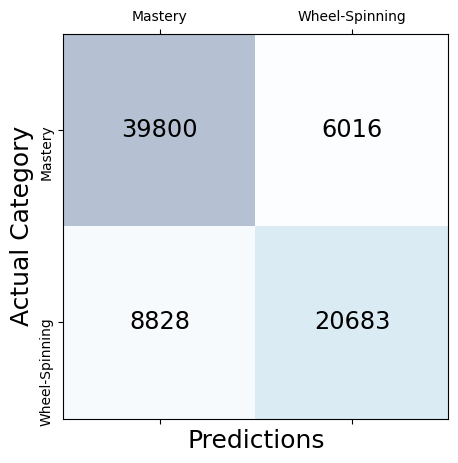

Precision: 77.46732087344095%
Recall: 70.08573074446817%


In [26]:
conf_matrix = acc_results[2]
conf_matrix_perc = conf_matrix / conf_matrix.sum()

fig, ax = plt.subplots(figsize = (5,5))
plt.xlabel('Predictions', fontsize = 18)
plt.ylabel('Actual Category', fontsize = 18)
ax.matshow(conf_matrix, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x = j, y = i, s = conf_matrix[i, j], va = 'center', ha = 'center', size = 'xx-large')

ax.set_xticklabels([''] + ['Mastery', 'Wheel-Spinning'])
ax.set_yticklabels([''] + ['Mastery', 'Wheel-Spinning'], rotation = 90)

plt.show()
# From this we can compute the precision and recall:
# Precision: 
precision  = conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[0][1])
recall = conf_matrix[1][1] / (conf_matrix[1][0] + conf_matrix[1][1])
print(f"Precision: {precision * 100}%")
print(f"Recall: {recall * 100}%")

Confusion matrix in raw number terms on user-skill pairs. For further analysis see report.

C:\Users\david\AppData\Local\Temp\ipykernel_16932\3053567116.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + ['Mastery', 'Wheel-Spinning'])
C:\Users\david\AppData\Local\Temp\ipykernel_16932\3053567116.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + ['Mastery', 'Wheel-Spinning'], rotation = 90)


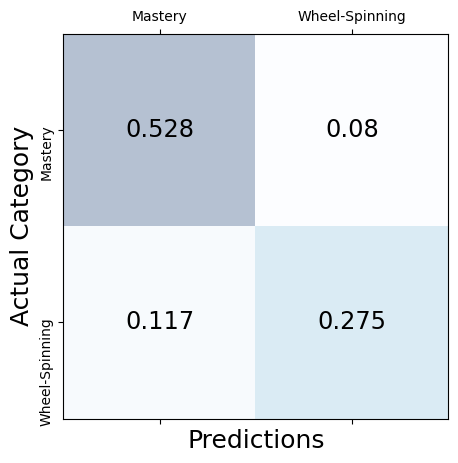

In [27]:
fig, ax = plt.subplots(figsize = (5, 5))
plt.xlabel('Predictions', fontsize = 18)
plt.ylabel('Actual Category', fontsize = 18)

ax.matshow(conf_matrix_perc, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(conf_matrix_perc.shape[0]):
    for j in range(conf_matrix_perc.shape[1]):
        ax.text(x = j, y = i, s = np.round(conf_matrix_perc[i, j], 3), va = 'center', ha = 'center', size = 'xx-large')

ax.set_xticklabels([''] + ['Mastery', 'Wheel-Spinning'])
ax.set_yticklabels([''] + ['Mastery', 'Wheel-Spinning'], rotation = 90)
plt.show()

Confusion matrix in percentage terms on user-skill pairs. For further analysis see report.

### Timeseries Analysis of Model Precision, Recall, Accuracy, and AUC  
Here we train the model on the training set once, then evaluate the models performance as we increase the practice opportunity from 1 to the cutoff, allowing us to see how the models ability evolves as more and more practice opportunities are present. This is in line with analysis and plots from the guiding paper.

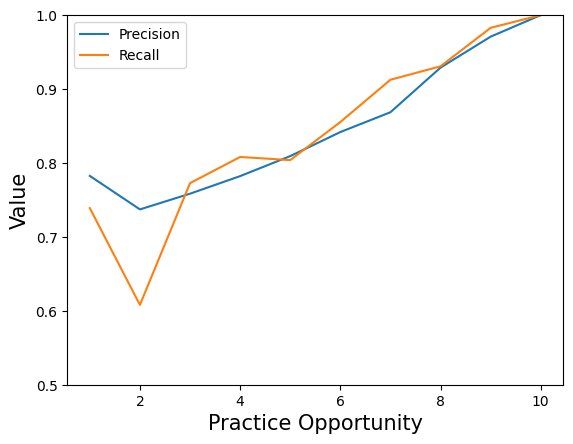

In [28]:
precisions = []
recalls = []
conf_matrices = []
accuracies = []
aucs = []
best_model = RandomForestClassifier(
    n_estimators = best_acc_hyperparameters[0],
    max_depth = best_acc_hyperparameters[1],
    criterion = FOREST_CRITERION
)
best_model.fit(X_train, y_train)
for i in range(1, PO_CUTOFF + 1):
    limited_validation = dataset[dataset.user_id.isin(validation_users)]
    limited_validation = limited_validation[limited_validation.po == i]
    y_lim_val = limited_validation.is_wheelspinning
    X_lim_val = limited_validation.drop(columns=['user_id', 'is_wheelspinning'])
    y_pred = model.predict(X_lim_val)
    accuracy = balanced_accuracy_score(y_lim_val, y_pred)

    y_pred_proba = model.predict_proba(X_lim_val)[:,1]
    conf_matrix = confusion_matrix(y_lim_val, y_pred)
    auc = roc_auc_score(y_lim_val, y_pred_proba)
    
    accuracies.append(accuracy)
    aucs.append(auc)
    conf_matrices.append(conf_matrix)
    precisions.append(conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[0][1]))
    recalls.append(conf_matrix[1][1] / (conf_matrix[1][0] + conf_matrix[1][1]))

plt.plot([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], precisions)
plt.plot([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], recalls)
plt.ylim([0.5, 1])
plt.xlabel('Practice Opportunity', fontsize = 15)
plt.ylabel('Value', fontsize = 15)
plt.legend(['Precision', 'Recall'])
plt.show()



This plot shows how the precision and recall evolves with practice opportunity. See report for further analysis.

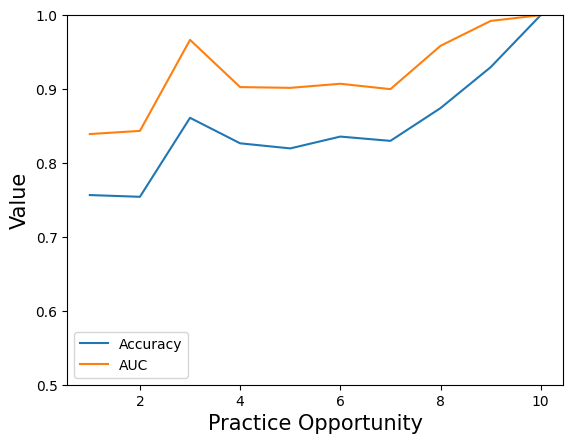

In [29]:
plt.plot([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], accuracies)
plt.plot([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], aucs)
plt.xlabel('Practice Opportunity', fontsize = 15)
plt.ylabel('Value', fontsize = 15)
plt.legend(['Accuracy', 'AUC'])
plt.ylim([0.5, 1])
plt.show()

This plot shows how the accuracy and auc evolves with practice opportunity. See report for further analysis

## @ DECLAN / ANYONE: CELLS FOR LOGISTIC REGRESSION EVALUATION 

## @ANYONE: Cells for kNN Evaluation:

## @ANYONE: CELLS FOR NEURAL NETWORK EVALUATION:

## @DAVID CELLS FOR FEATURE IMPORTANCE ANALYSIS

In [30]:
# TODO:

# run the fitting and stuff again with modified dataframes as input
# first, drop some features which might not have the biggest impact as the percentages as they are fully correlating with the counts
# then run it with fully isolated features, i. e. correct responses in a row or the time on this skill or just total correct responses
# evaluate everything
# compare the results

## Task 4: Team Reflection
Please describe the contributions of each team member to Milestone 4. Reflect on how you worked as team: what went well, what can be improved for the next milestone?

### Distribution of work:
1. Choosing topic and initial examination of literature: all members  
2. Choosing model, features, and approach: all members
3. Data Preprocessing: Declan and Oliver
4. Feature Extraction: Declan and Oliver
5. Model Training: Declan
6. Model Evaluation: Oliver
7. Preparation of Report: David
8. Initial Draft of Report: Oliver
9. Finalization of Report: Declan and Oliver
10. Proof-reading of Report: David
11. Cleaning up notebook and adding comments/discussion: Declan and Oliver

### Reflection:
Communication went well for the most part, but distribution of work could have been more fairly allocated and will aim to improve for the following milestone.